In [961]:
import pandas as pd
import numpy as np

from scipy.optimize import minimize
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

In [962]:
initial_amout = 1_000

## Functions

In [963]:
## Final metrics

def annual_volatility(portfolio_returns):
    return portfolio_returns.std() * np.sqrt(252)

def sharpe_ratio(portfolio_returns):
    vol_annual = annual_volatility(portfolio_returns)
    ret_annual = portfolio_returns.mean() * 252
    return ret_annual / vol_annual

## HRP

def get_quasi_diag(link):
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])

    num_items = link[-1, 3]

    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df1 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df1])
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])

    return sort_ix.tolist()

def get_cluster_var(cov, cluster_items):
    cov_slice = cov.loc[cluster_items, cluster_items]
    inv_diag = 1. / np.diag(cov_slice)
    weights = inv_diag / inv_diag.sum()
    return weights @ cov_slice.values @ weights

def get_rec_bipart(cov, sort_ix):
    weights = pd.Series(1, index=sort_ix)
    clusters = [sort_ix]

    while len(clusters) > 0:
        clusters = [
            cluster[i:j]
            for cluster in clusters
            for i, j in ((0, len(cluster) // 2), (len(cluster) // 2, len(cluster)))
            if len(cluster) > 1
        ]

        for i in range(0, len(clusters), 2):
            cluster0 = clusters[i]
            cluster1 = clusters[i + 1]

            var0 = get_cluster_var(cov, cluster0)
            var1 = get_cluster_var(cov, cluster1)

            alpha = 1 - var0 / (var0 + var1)

            weights[cluster0] *= alpha
            weights[cluster1] *= 1 - alpha

    return weights


## MVO 
def optimize_portfolio(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    def portfolio_performance(weights):
        portfolio_returns = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return portfolio_returns, portfolio_volatility
    
    def negative_sharpe_ratio(weights, risk_free_rate=0):
        p_returns, p_volatility = portfolio_performance(weights)
        return - (p_returns - risk_free_rate) / p_volatility

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))
    initial_guess = returns.shape[1] * [1. / returns.shape[1]]

    optimized_result = minimize(negative_sharpe_ratio, initial_guess,
                                method='SLSQP', bounds=bounds,
                                constraints=constraints)

    return optimized_result.x

## mCVAR

def calculate_cvar(returns, confidence_level):
    var = np.percentile(returns, 100 * (1 - confidence_level))

    cvar = returns[returns <= var].mean()

    return cvar


def optimize_mcvar(returns, confidence_level=0.95):
    tickers = returns.columns
    n_tickers = len(tickers)

    def objective(weights):
        portfolio_returns = returns.dot(weights)
        return calculate_cvar(portfolio_returns, confidence_level)

    constraints = ({
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    })

    bounds = [(0, 1)] * n_tickers

    initial_weights = np.ones(n_tickers) / n_tickers

    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

    return result.x

## HRP

/var/folders/m3/hw_q9vg90sn6svthrgc9b2th0000gn/T/ipykernel_84732/2868609451.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58453367]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[cluster0] *= alpha


<Axes: title={'center': 'Average True Range'}, xlabel='Date'>

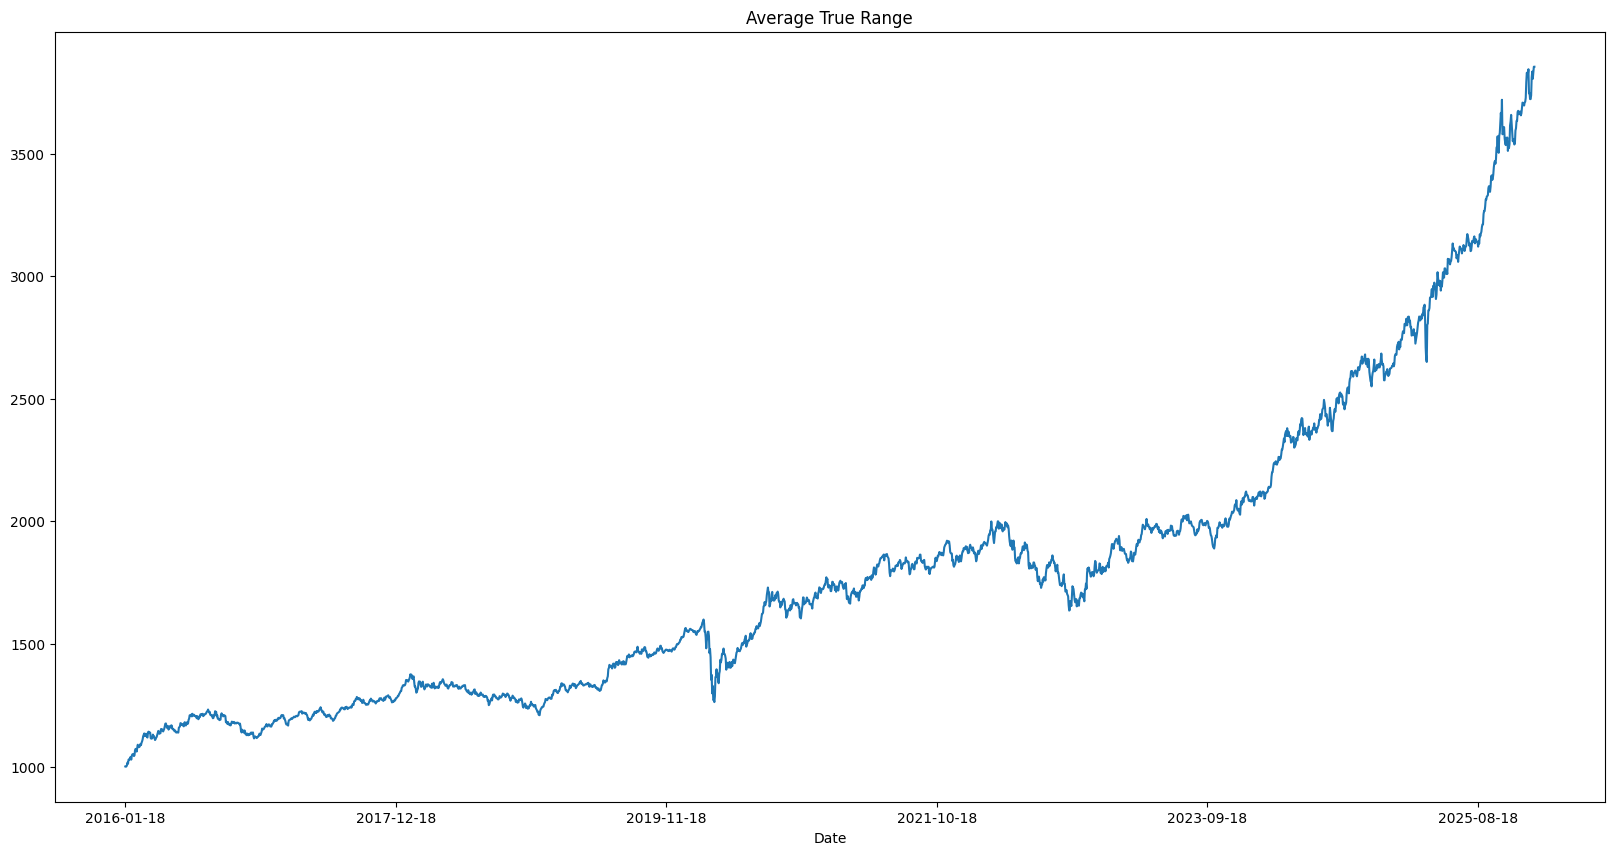

In [964]:
hrp_for_returns = pd.read_csv("../data/returns/data_returns.csv", index_col="Date")

hrp_corr = hrp_for_returns.corr()
hrp_cov = hrp_for_returns.cov()

portfolio_value = initial_amout

corr_distance = np.sqrt((1-hrp_corr)*0.5)
dist_condensed = squareform(corr_distance.values)
link = linkage(dist_condensed, 'single')
sort_ix = get_quasi_diag(link)
sort_ix = hrp_for_returns.columns[sort_ix]
hrp_weights = get_rec_bipart(hrp_cov, sort_ix)
hrp_weights = hrp_weights.sort_index()

hrp_returns = (hrp_for_returns * hrp_weights).sum(axis=1)

hrp_evolution = portfolio_value * (1 + hrp_returns).cumprod()
hrp_final_value = portfolio_value * (1 + hrp_returns).prod()

hrp_evolution.plot(title="Average True Range", figsize=(20,10))


### Results analysis

In [965]:
hrp_vol_annual = annual_volatility(hrp_returns)
hrp_sharpe_ratio = sharpe_ratio(hrp_returns)

print(f"Sharpe Ratio: {hrp_sharpe_ratio}\nFinal Value: {hrp_final_value}\nVolatility: {hrp_vol_annual*100}%\nWeights:\n{hrp_weights}")

Sharpe Ratio: 1.1738732622729386
Final Value: 3854.1835827372115
Volatility: 11.700822310041616%
Weights:
GLD     0.584534
URTH    0.345095
USO     0.070371
dtype: float64


## MVO

<Axes: title={'center': 'MVO Powered Portfolio'}, xlabel='Date'>

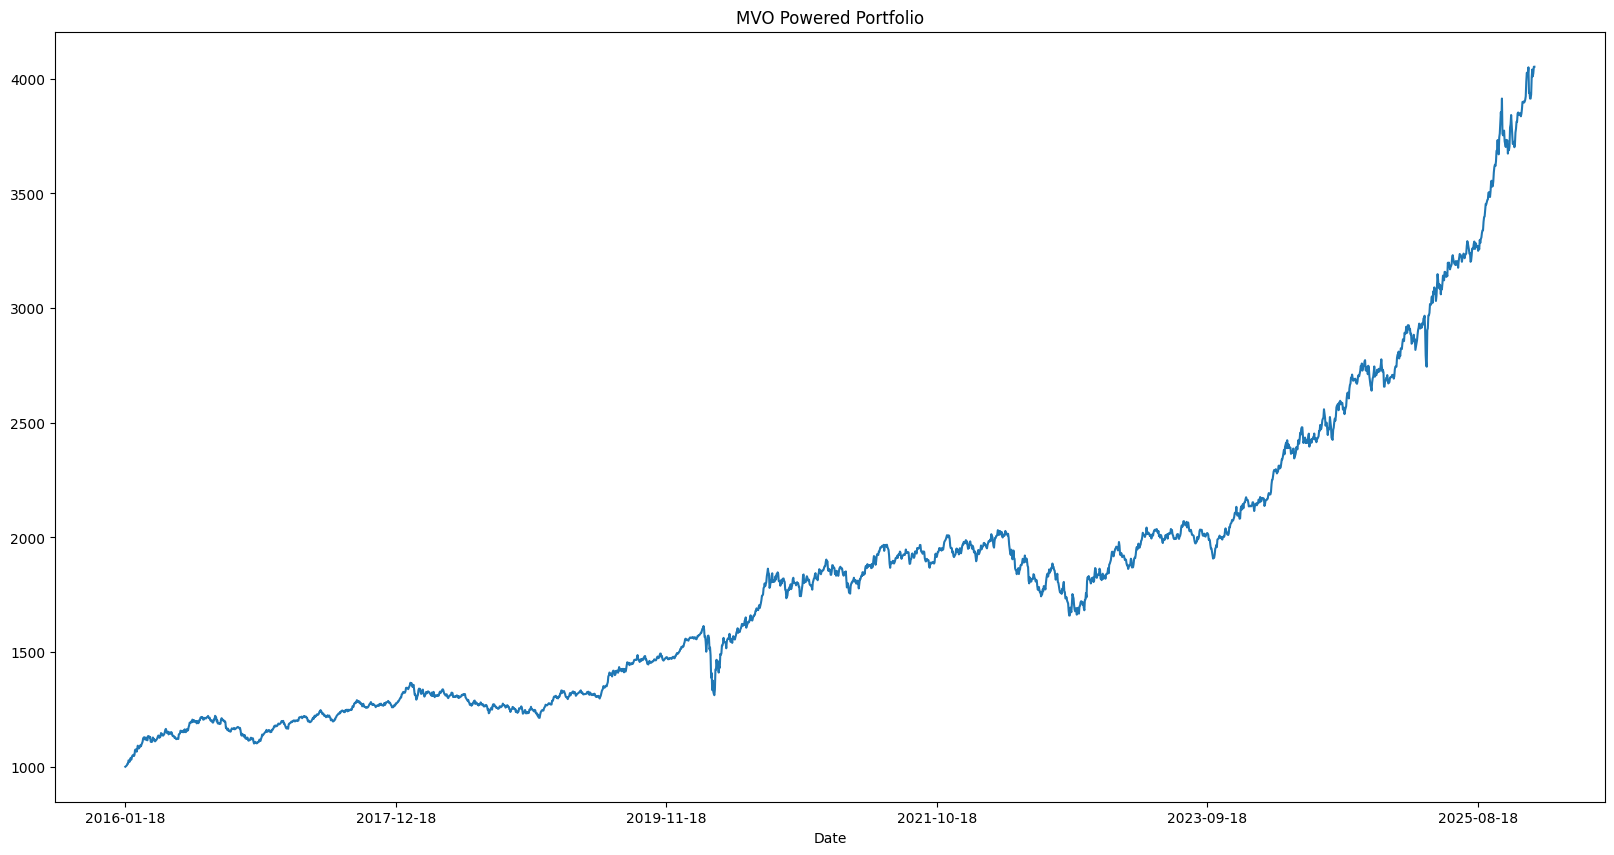

In [966]:
return_for_mvo = pd.read_csv("../data/returns/data_returns.csv", index_col="Date")

mvo_corr = return_for_mvo.corr()
mvo_cov = return_for_mvo.cov()

portfolio_value = initial_amout

mvo_weights = optimize_portfolio(return_for_mvo)

mvo_returns = (return_for_mvo * mvo_weights).sum(axis=1)

mvo_evolution = portfolio_value * (1 + mvo_returns).cumprod()
mvo_final_value = portfolio_value * (1 + mvo_returns).prod()

mvo_evolution.plot(title="MVO Powered Portfolio", figsize=(20,10))


In [967]:
mvo_vol_annual = annual_volatility(mvo_returns)
mvo_sharpe_ratio = sharpe_ratio(mvo_returns)

print(f"Sharpe Ratio: {mvo_sharpe_ratio}\nFinal Value: {mvo_final_value}\nVolatility: {mvo_vol_annual*100}%\nWeights:\n{mvo_weights}")

Sharpe Ratio: 1.2281931276665523
Final Value: 4052.8780996540945
Volatility: 11.565903968974153%
Weights:
[0.         0.40287582 0.59712418]


## mCVAR

<Axes: title={'center': 'mCVAR'}, xlabel='Date'>

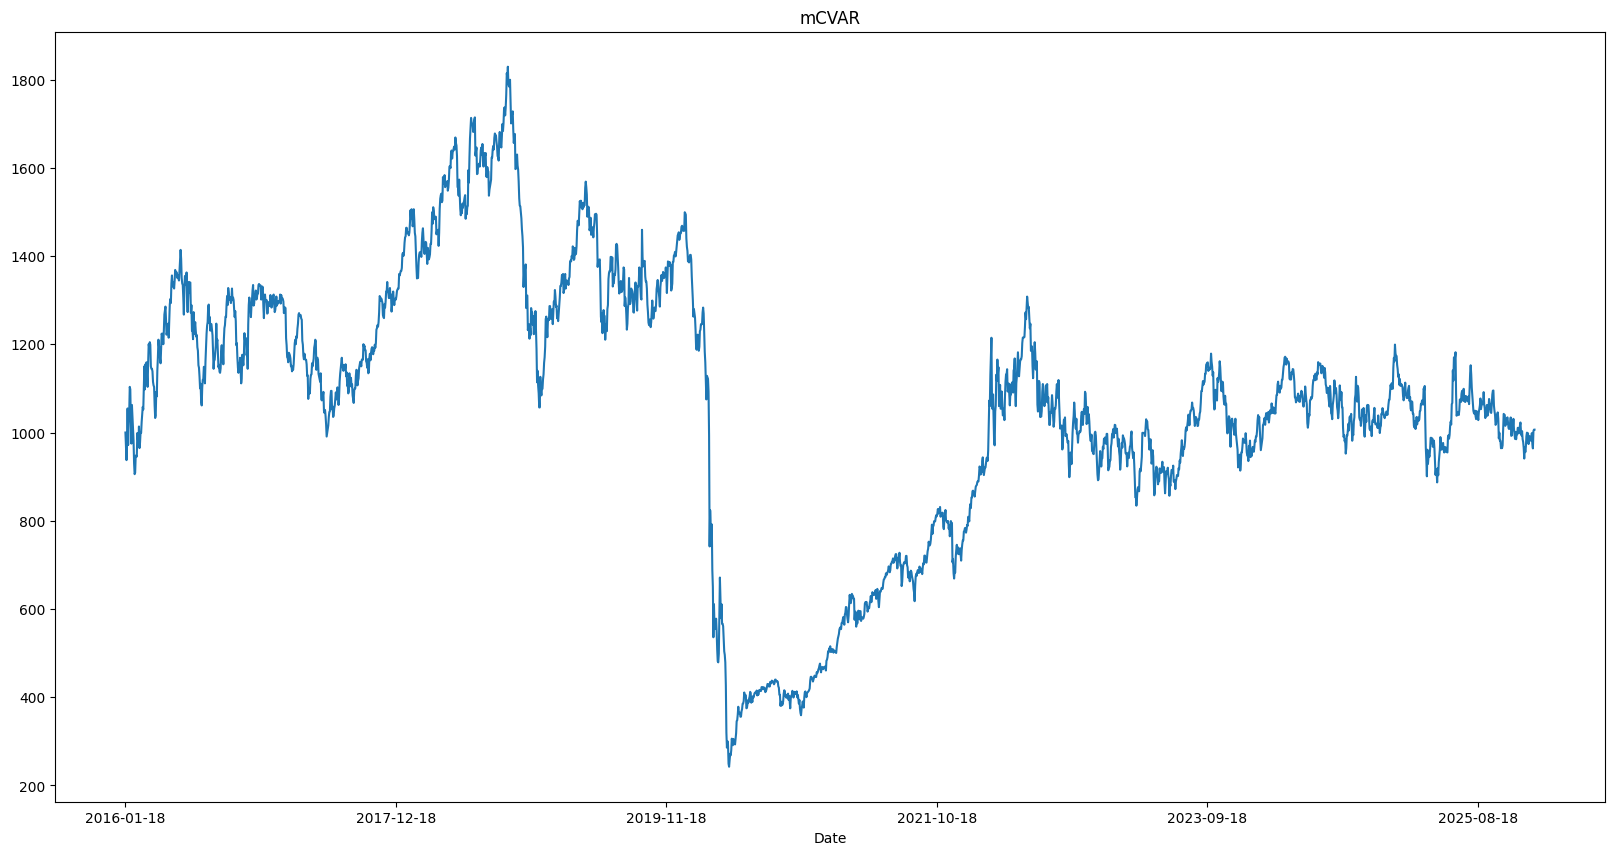

In [968]:
mcvar_for_returns = pd.read_csv("../data/returns/data_returns.csv", index_col="Date")

hrp_corr = mcvar_for_returns.corr()
hrp_cov = mcvar_for_returns.cov()

portfolio_value = initial_amout

mcvar_weights = optimize_mcvar(mcvar_for_returns)

mcvar_returns = (mcvar_for_returns * mcvar_weights).sum(axis=1)

mcvar_evolution = portfolio_value * (1 + mcvar_returns).cumprod()
mcvar_final_value = portfolio_value * (1 + mcvar_returns).prod()

mcvar_evolution.plot(title="mCVAR", figsize=(20,10))


In [969]:
mcvar_vol_annual = annual_volatility(mcvar_returns)
mcvar_sharpe_ratio = sharpe_ratio(mcvar_returns)

print(f"Sharpe Ratio: {mcvar_sharpe_ratio}\nFinal Value: {mcvar_final_value}\nVolatility: {mcvar_vol_annual*100}%\nWeights:\n{mcvar_weights}")

Sharpe Ratio: 0.19400388720671582
Final Value: 1006.5415114686118
Volatility: 37.63690217477602%
Weights:
[1.00000000e+00 0.00000000e+00 6.23868772e-16]


<Axes: title={'center': 'Comparison'}, xlabel='Date'>

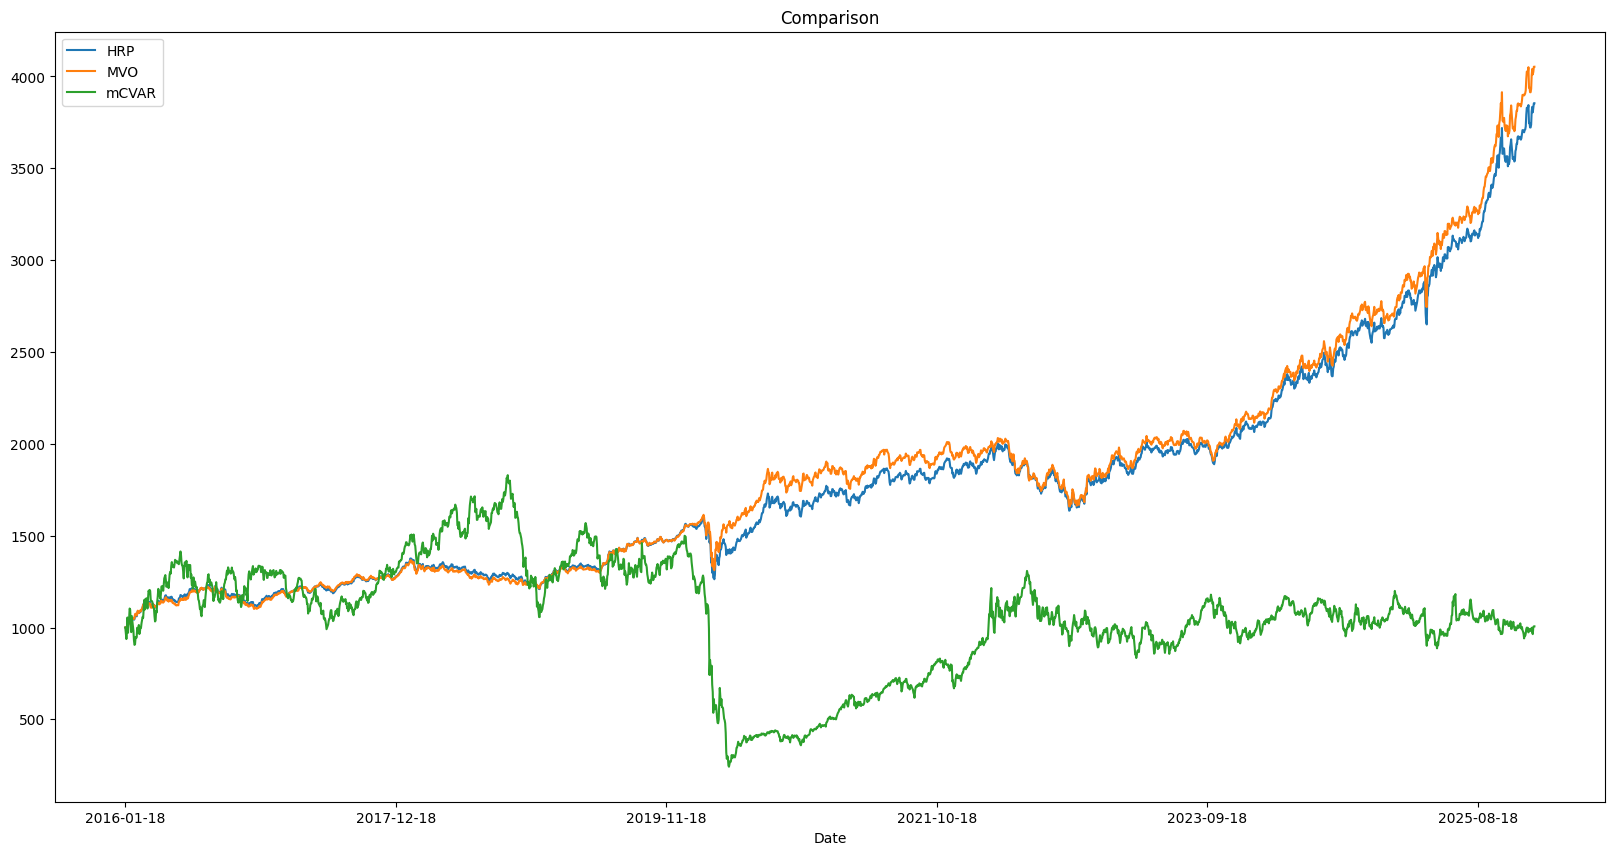

In [970]:
all_strat = pd.concat([hrp_evolution,mvo_evolution, mcvar_evolution],axis=1)
df = all_strat.rename(columns={0 : "HRP", 1 : 'MVO', 2 : "mCVAR"})
df.plot(title="Comparison", figsize=(20,10))